In [41]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
import numpy as np
import re
from sklearn.impute import SimpleImputer





In [42]:
df=pd.read_csv("weather.csv")
print("Dimension de la Base: ",df.shape)
data_type=dict()
for i in range (0,30):
    data_type[df.columns[i]]=df[df.columns[i]].dtype
    
print("Types des données : ",data_type)
print("les valeurs manquantes : ")
print(df.isnull().sum())
print(df.describe())
print()


Dimension de la Base:  (119040, 31)
Types des données :  {'STA': dtype('int64'), 'Date': dtype('O'), 'Precip': dtype('O'), 'WindGustSpd': dtype('float64'), 'MaxTemp': dtype('float64'), 'MinTemp': dtype('float64'), 'MeanTemp': dtype('float64'), 'Snowfall': dtype('O'), 'PoorWeather': dtype('O'), 'YR': dtype('int64'), 'MO': dtype('int64'), 'DA': dtype('int64'), 'PRCP': dtype('O'), 'DR': dtype('float64'), 'SPD': dtype('float64'), 'MAX': dtype('float64'), 'MIN': dtype('float64'), 'MEA': dtype('float64'), 'SNF': dtype('O'), 'SND': dtype('float64'), 'FT': dtype('float64'), 'FB': dtype('float64'), 'FTI': dtype('float64'), 'ITH': dtype('float64'), 'PGT': dtype('float64'), 'TSHDSBRSGF': dtype('O'), 'SD3': dtype('float64'), 'RHX': dtype('float64'), 'RHN': dtype('float64'), 'RVG': dtype('float64')}
les valeurs manquantes : 
STA                 0
Date                0
Precip              0
WindGustSpd    118508
MaxTemp             0
MinTemp             0
MeanTemp            0
Snowfall         1163


C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_23960\3447635443.py:1: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("weather.csv")


Visualisation


=======features========
Index(['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp',
       'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR',
       'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH',
       'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE'],
      dtype='object')


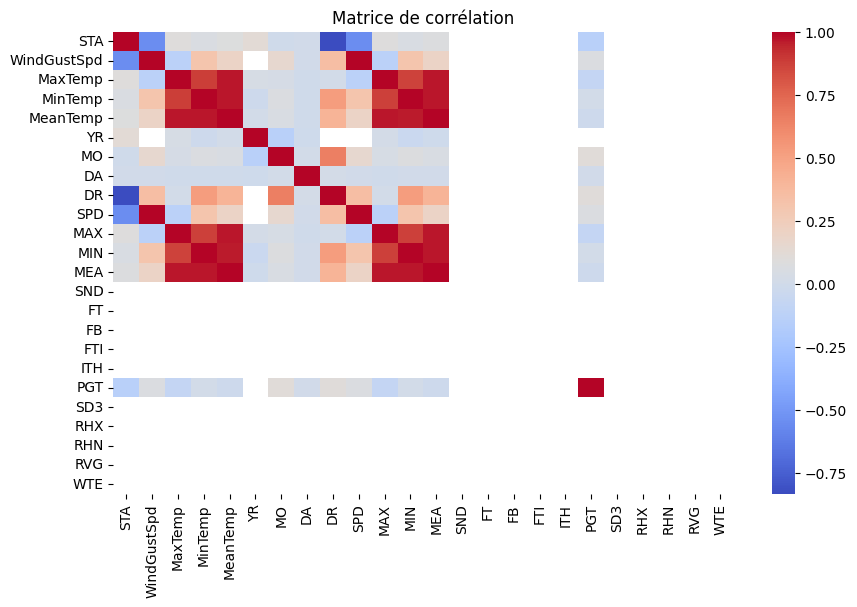

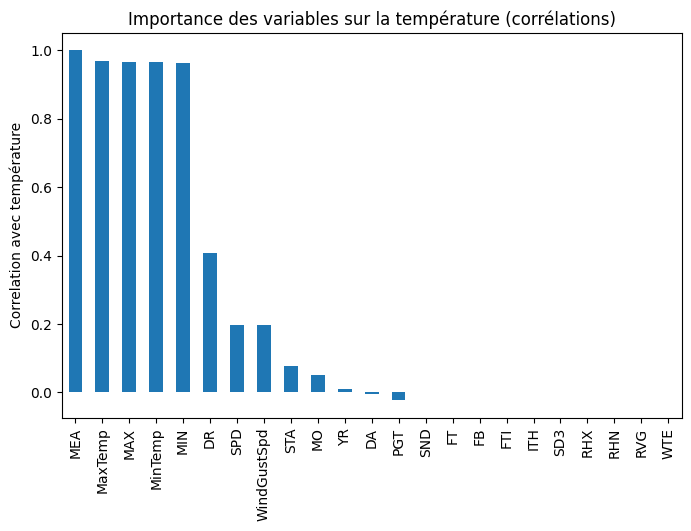

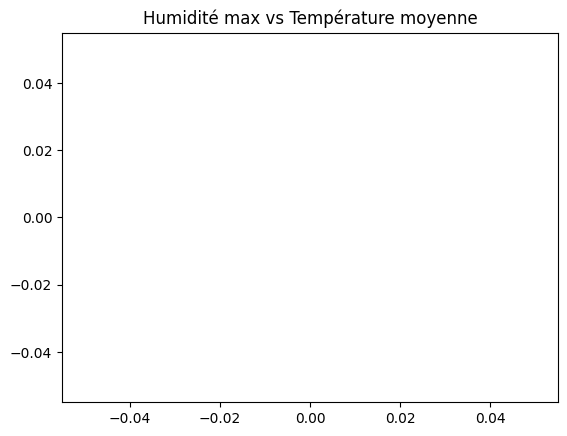

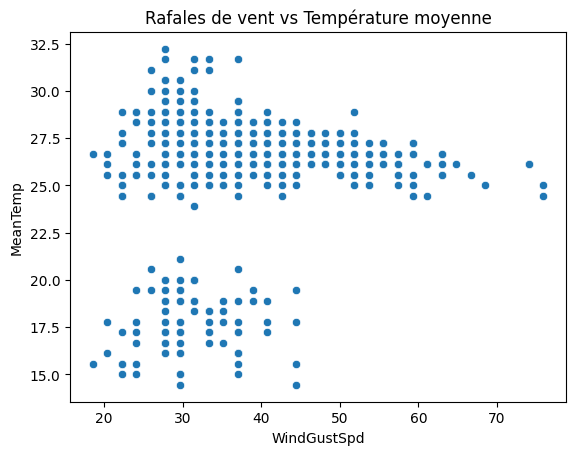

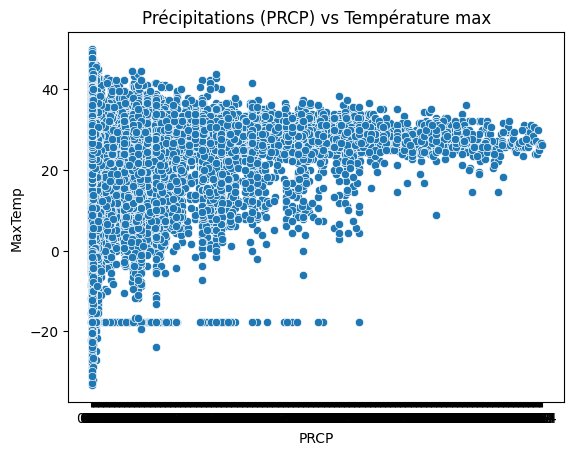

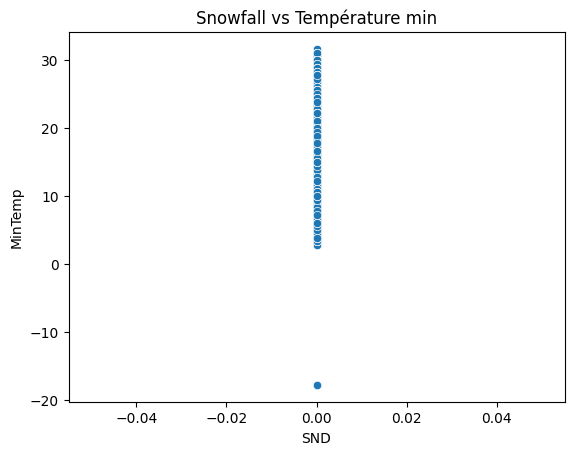

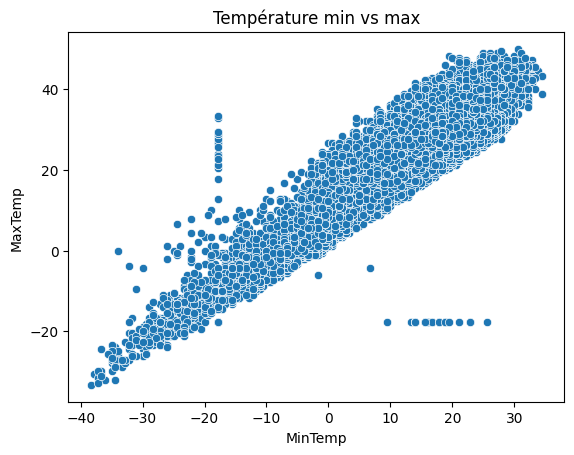

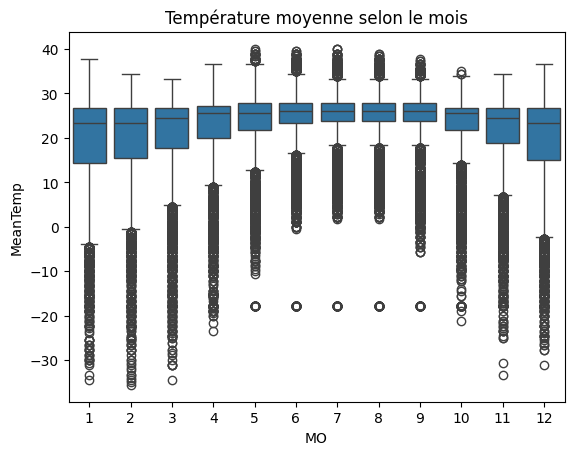

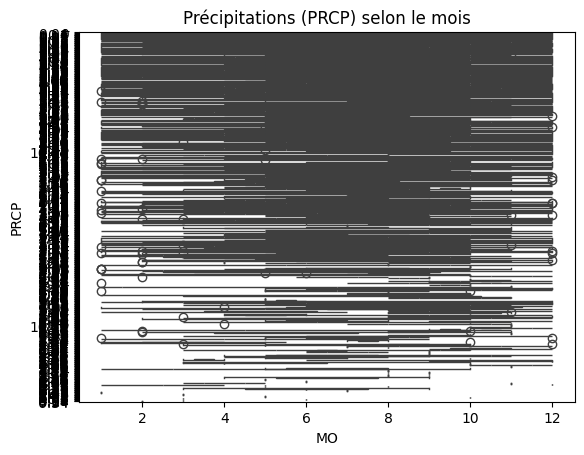

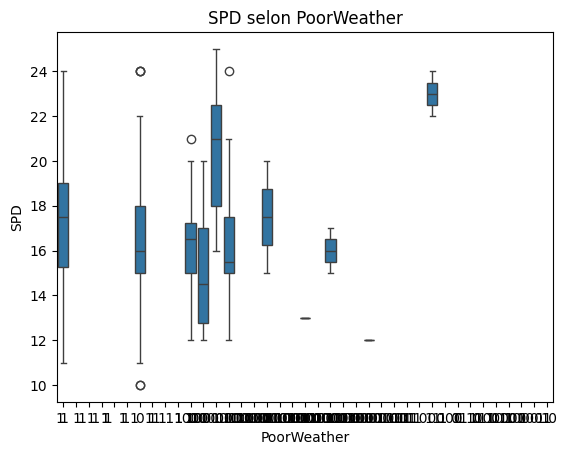

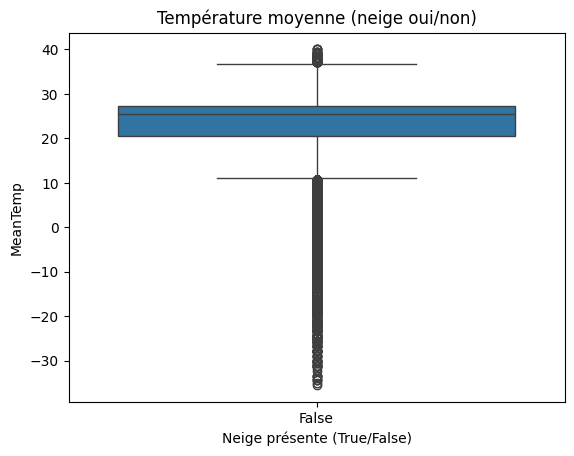

In [43]:
print("=======features========")
print(df.columns)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

corr_temp = df.corr(numeric_only=True)["MeanTemp"].sort_values(ascending=False)

plt.figure(figsize=(8,5))
corr_temp.drop("MeanTemp").plot(kind="bar")
plt.title("Importance des variables sur la température (corrélations)")
plt.ylabel("Correlation avec température")
plt.show()

# Humidité max vs Température moyenne
sns.scatterplot(df, x="RHX", y="MeanTemp")
plt.title("Humidité max vs Température moyenne")
plt.show()

# Rafales de vent vs Température moyenne
sns.scatterplot(df, x="WindGustSpd", y="MeanTemp")
plt.title("Rafales de vent vs Température moyenne")
plt.show()

# Précipitations vs Température max
sns.scatterplot(df, x="PRCP", y="MaxTemp")
plt.title("Précipitations (PRCP) vs Température max")
plt.show()

# Chute de neige vs Température min
sns.scatterplot(df, x="SND", y="MinTemp")
plt.title("Snowfall vs Température min")
plt.show()

# Température min vs max
sns.scatterplot(df, x="MinTemp", y="MaxTemp")
plt.title("Température min vs max")
plt.show()



# ---------- BOX PLOTS ----------

# Température moyenne par mois
sns.boxplot(df, x="MO", y="MeanTemp")
plt.title("Température moyenne selon le mois")
plt.show()

# Précipitations par mois
sns.boxplot(df, x="MO", y="PRCP")
plt.title("Précipitations (PRCP) selon le mois")
plt.show()

# Vitesse du vent selon PoorWeather
sns.boxplot(df, x="PoorWeather", y="SPD")
plt.title("SPD selon PoorWeather")
plt.show()

# Température moyenne selon présence de neige
sns.boxplot(df, x=(df["SND"] > 0), y="MeanTemp")
plt.title("Température moyenne (neige oui/non)")
plt.xlabel("Neige présente (True/False)")
plt.show()



PRETRAITEMENT

In [44]:

print("=======features========")
print(df.columns)

# Colonnes entièrement vides donc suppression
empty_cols = df.columns[df.isna().all()]
print("Empty columns:", list(empty_cols))
df.drop(columns=empty_cols, inplace=True)
print("=======features========")
print(df.columns)

colonne_a_supprimer = [
    'STA', 'Date','Precip','WindGustSpd', 'DR', 'SPD', 'SND','FT', 'FB', 'FTI', 'ITH', 'PGT',
    'SD3','RHX', 'RHN', 'RVG', 'WTE', 'TSHDSBRSGF','MAX', 'MIN', 'MEA','YR','DA','SNF','MaxTemp','Snowfall'
]
df.drop(columns=colonne_a_supprimer, errors='ignore', inplace=True)

# ----- CLEANING TEXT VALUES (vectorized, no applymap) -----
# On cible uniquement les colonnes de type object =strings
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Object-like columns to clean:", obj_cols)

if obj_cols:
    # 1) strip et remplacer virgule décimale par point
    df.loc[:, obj_cols] = df.loc[:, obj_cols].apply(lambda col: col.str.strip().str.replace(',', '.', regex=False))
    # 2) garder uniquement chiffres, '.', '-' ; remplacer chaînes vides par pd.NA
    df.loc[:, obj_cols] = df.loc[:, obj_cols].apply(
        lambda col: col.str.replace(r'[^0-9\.\-]', '', regex=True).replace('', pd.NA)
    )
    ######################################################################
    #NB=> les étapes précédantes, a mon avis, ne sont pas vraiment "safe" car il se paut qu'une case a par exemple "1 1 1" et le code l'interprete comme "111" alors qui'il sagit de "1" mais ecrite plusierus fois par hasard.
    ######################################################################
# ----- CONVERT TO NUMERIC (non-convertibles -> NaN) -----
df = df.apply(pd.to_numeric, errors="coerce")

# ----- CHECK TARGET -----
TARGET = "MeanTemp"
if TARGET not in df.columns:
    raise KeyError(f"Colonne cible '{TARGET}' introuvable dans le DataFrame après nettoyage.")

# ----- PREPARE X/y -----
y = df[TARGET].copy()
X = df.drop(columns=[TARGET]).copy()
print("=======features restantes ========")
print(X.columns)
print("Shape before split:", X.shape)

# ----- SPLIT (avant imputation/scaling) -----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----- IMPUTATION (médiane) -----
imp = SimpleImputer(strategy='median')
X_train_imputed = imp.fit_transform(X_train)   # fit on train only
X_test_imputed  = imp.transform(X_test)

# ----- SCALING -----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled  = scaler.transform(X_test_imputed)

# ----- SAVE ARTIFACTS -----
joblib.dump(imp, "weather_imputer.pkl")
joblib.dump(scaler, "weather_scaler.pkl")

print("Shape train:", X_train.shape, "->", X_train_scaled.shape)
print("Shape test:", X_test.shape, "->", X_test_scaled.shape)


=======features========
Index(['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp',
       'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR',
       'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH',
       'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE'],
      dtype='object')
Empty columns: ['FT', 'FB', 'FTI', 'ITH', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']
=======features========
Index(['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp',
       'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR',
       'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'PGT', 'TSHDSBRSGF'],
      dtype='object')
Object-like columns to clean: ['PoorWeather', 'PRCP']
=======features restantes ========
Index(['MinTemp', 'PoorWeather', 'MO', 'PRCP'], dtype='object')
Shape before split: (119040, 4)
Shape train: (95232, 4) -> (95232, 4)
Shape test: (23808, 4) -> (23808, 4)


MODELISATION

In [45]:

LR = LinearRegression()
LR.fit(X_train_scaled, y_train)
y_pred = LR.predict(X_test_scaled)


DT = DecisionTreeRegressor(max_depth=5, random_state=42)
DT.fit(X_train_scaled, y_train)
y_pred_dt = DT.predict(X_test_scaled)
joblib.dump(DT, "weather_model.pkl")





['weather_model.pkl']

EVALUATION 


===== COMPARAISON DES MODÈLES =====
                         RMSE       MSE       MAE        R2
Régression Linéaire  2.076209  4.310642  1.575789  0.936545
Arbre de Décision    1.921450  3.691970  1.407274  0.945652


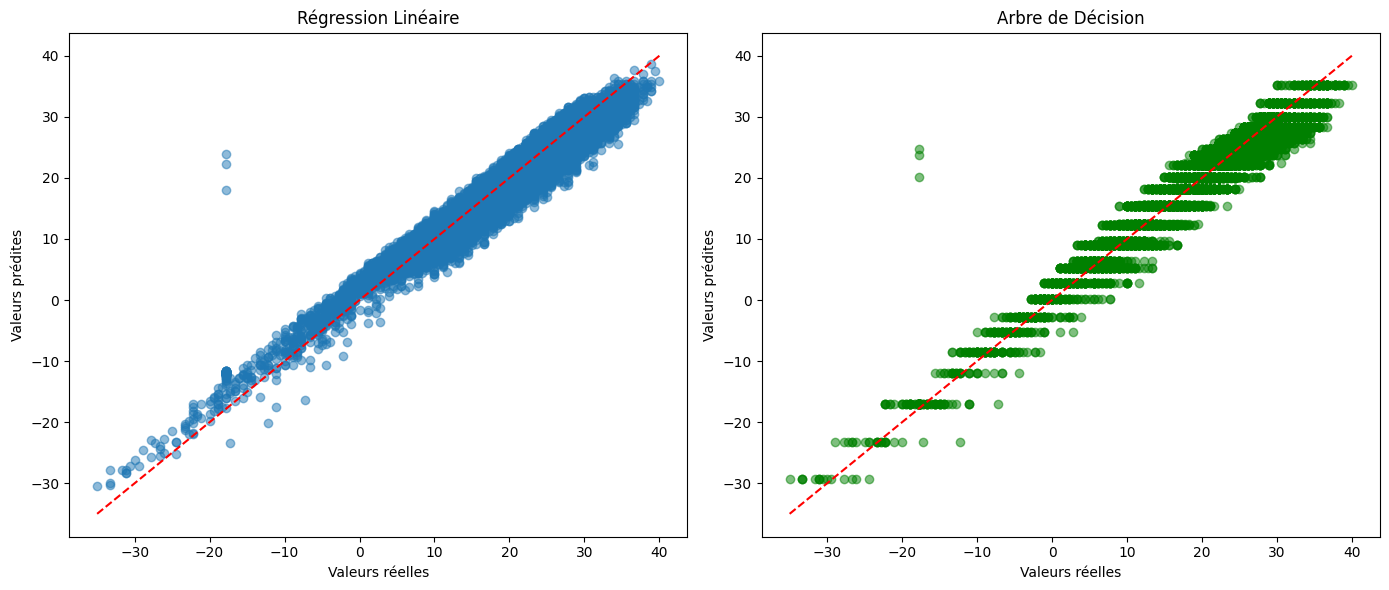


===== Importance des variables (Arbre de Décision) =====
       Feature  Importance
0      MinTemp    0.995492
3         PRCP    0.004508
1  PoorWeather    0.000000
2           MO    0.000000

===== Coefficients (Régression Linéaire) =====
       Feature  Coefficient
0      MinTemp     8.059178
1  PoorWeather     0.044510
2           MO    -0.120227
3         PRCP    -0.316710


In [46]:


results = pd.DataFrame({
    "RMSE": [np.sqrt(mean_squared_error(y_test, y_pred)),
             np.sqrt(mean_squared_error(y_test, y_pred_dt))],
    "MSE": [mean_squared_error(y_test, y_pred),
            mean_squared_error(y_test, y_pred_dt)],
    "MAE": [mean_absolute_error(y_test, y_pred),
            mean_absolute_error(y_test, y_pred_dt)],
    "R2":  [r2_score(y_test, y_pred),
            r2_score(y_test, y_pred_dt)]
},
index=["Régression Linéaire", "Arbre de Décision"])

print("\n===== COMPARAISON DES MODÈLES =====")
print(results)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Linear Regression plot ---
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_title("Régression Linéaire")
axes[0].set_xlabel("Valeurs réelles")
axes[0].set_ylabel("Valeurs prédites")

# --- Decision Tree plot ---
axes[1].scatter(y_test, y_pred_dt, alpha=0.5, color="green")
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1].set_title("Arbre de Décision")
axes[1].set_xlabel("Valeurs réelles")
axes[1].set_ylabel("Valeurs prédites")

plt.tight_layout()
plt.show()


importance_dt = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": DT.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n===== Importance des variables (Arbre de Décision) =====")
print(importance_dt)

coef_lr = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": LR.coef_
}).sort_values("Coefficient", ascending=False)

print("\n===== Coefficients (Régression Linéaire) =====")
print(coef_lr)



TACHE FINALE: CREATION D'UNE FONCTION DE TEST

In [47]:
def tester_weather(x):
    model = joblib.load("weather_model.pkl")
    imputer = joblib.load("weather_imputer.pkl")
    scaler = joblib.load("weather_scaler.pkl")

    x = np.array(x).reshape(1, -1)

    x_imputed = imputer.transform(x)
    x_scaled = scaler.transform(x_imputed)

    prediction = model.predict(x_scaled)[0]

    print(f"Température moyenne prédite : {prediction:.2f} °C")

In [48]:
#j'ai montré chatpgt le dataset pou qu'il ME DONNE DES SAMPLE POUR TESTER LE MODEL
# journée froide + un peu de pluie
sample1 = [-5, 0, 1, 3.2]

# journée normale sans événements météo
sample2 = [10, 0, 6, 0.0]

# journée chaude et sèche
sample3 = [25, 0, 7, 0.0]

tester_weather(sample1)
tester_weather(sample2)
tester_weather(sample3)


Température moyenne prédite : -2.70 °C
Température moyenne prédite : 15.39 °C
Température moyenne prédite : 28.31 °C


c:\Users\GIGABYTE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\GIGABYTE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\GIGABYTE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
